In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from IPython.display import Image
import cv2 as cv
import os
import pydot
from tensorflow.keras.layers import Dropout
from skimage.metrics import peak_signal_noise_ratio ,structural_similarity

2024-08-26 08:40:45.239028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 08:40:45.239150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 08:40:45.378711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model Architecture

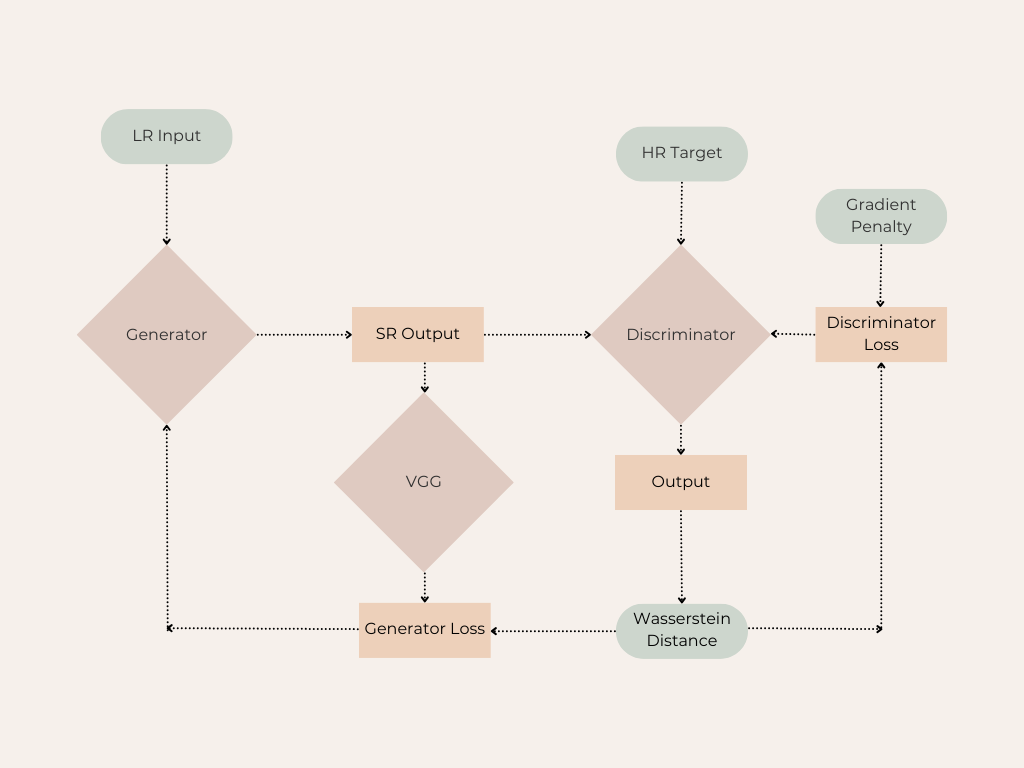

In [2]:
Image(filename='/kaggle/input/imd-architecture/Architecture_IMD.png')

# Data Loading and Processing

In [3]:
# Do not Modify
import pickle
SR_pic_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
with open(SR_pic_file_path, 'rb') as file:
    SR_pic_data = pickle.load(file)

In [4]:
for key in SR_pic_data:
    rainfall_array_final = [] 
    for j in range(SR_pic_data[key].shape[0]):
        k = SR_pic_data[key][j][1:,:]
        k = k[:,3:-4]
        rainfall_array_final.append(k)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_pic_data[key] = rainfall_array_final
print(SR_pic_data[1901][0].shape)

(128, 128)


### Generating LR images from SR images

In [5]:
def downsample(image):
    max_pooled_image = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(image)
    downsampled_image = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(max_pooled_image) 
    return downsampled_image
def Generating_Low_resolution_data(SR_data,LR):
    for year in range(1901,2024):
        lr = []
        for i in range(SR_data[year].shape[0]):
            nan_value = -9999
            filled_data = np.nan_to_num(SR_pic_data[year][i], nan=nan_value)
            input_image = filled_data.reshape((1,128,128,1))
            downsampled_image = np.array(downsample(input_image))
            downsampled_image[downsampled_image==nan_value] =np.nan
            lr.append(downsampled_image.reshape((32,32)))
        LR[year] = np.array(lr)
LR = {}
Generating_Low_resolution_data(SR_pic_data,LR)

In [6]:
def calculate_daily_max(SR_data):
    daily_max = {year: [0] * SR_data[year].shape[0] for year in range(1901, 2024)}

    for year in range(1901, 2024):
        for i in range(SR_data[year].shape[0]):
            daily_max[year][i] = np.nanmax(SR_data[year][i])

    return daily_max

def normalize_with_daily_max(SR_data, daily_max):
    for year in range(1901, 2024):
        for i in range(SR_data[year].shape[0]):
            max_value = daily_max[year][i]
            if max_value != 0:
                SR_data[year][i] /= max_value
                SR_data[year][i]+=1
            SR_data[year][i][np.isnan(SR_data[year][i])] = 0
    return SR_data

def Dataprocessing(SR_data):
    daily_max = calculate_daily_max(SR_data)
    SR_data = normalize_with_daily_max(SR_data, daily_max)
    return daily_max

In [7]:
daily_max_SR = Dataprocessing(SR_pic_data)
daily_max_LR = Dataprocessing(LR)

128 128


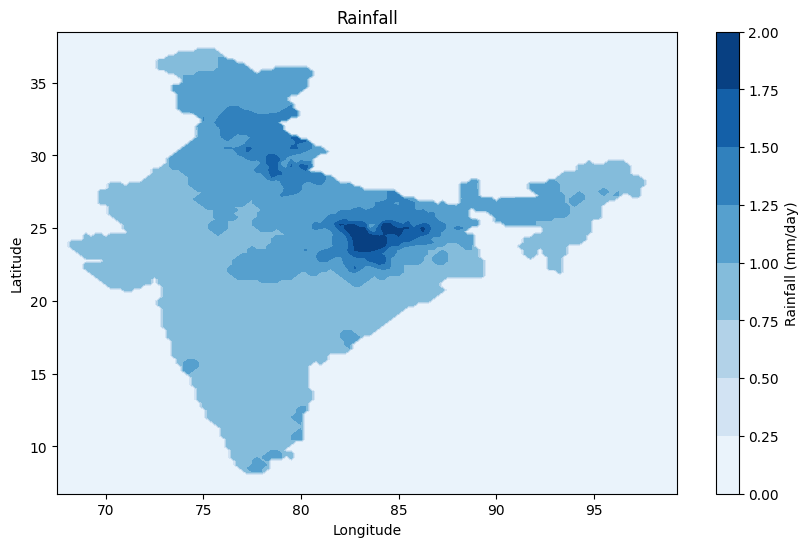

In [8]:
SR_rainfall = SR_pic_data[1901][0]
lat25 = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon25 = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')
lon25 = lon25[4:-4]
print(len(lat25),len(lon25))
plt.figure(figsize=(10, 6))
X_SR, Y_SR = np.meshgrid(lon25, lat25)
plt.contourf(X_SR, Y_SR, SR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

32 32
(32, 32)


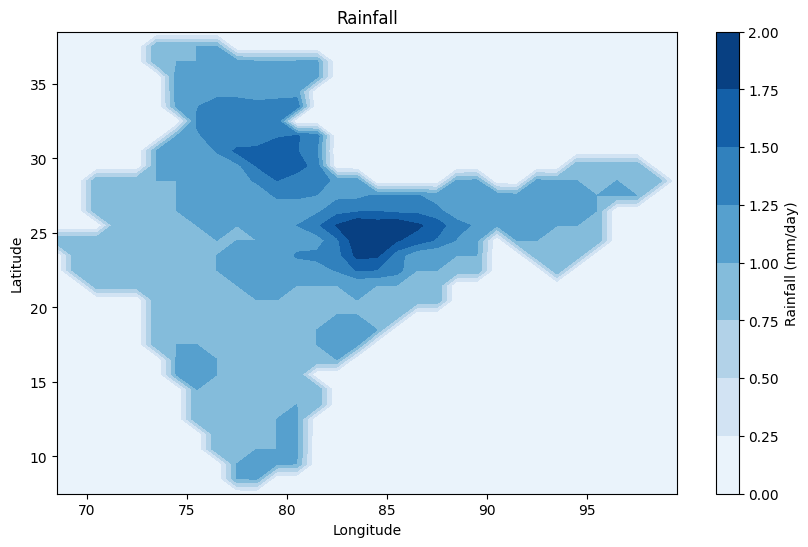

In [9]:
LR_rainfall = LR[1901][0]
lat1 = np.load('/kaggle/input/coordinates-imd/1lat.npy')
lon1 = np.load('/kaggle/input/coordinates-imd/1lon.npy')
lon1 = lon1[1:-1]
print(len(lat1),len(lon1))
print(LR_rainfall.shape)
plt.figure(figsize=(10, 6))
X_LR, Y_LR = np.meshgrid(lon1, lat1)
plt.contourf(X_LR, Y_LR, LR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Generator

In [10]:
class DepthToSpaceLayer(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)
def residual_block_gen(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])
    return model
def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same')(x)
    x = DepthToSpaceLayer(block_size=2)(x)  
    x = tf.keras.layers.LeakyReLU()(x)
    return x
input_lr = tf.keras.layers.Input(shape=(None, None, 1))
input_conv = tf.keras.layers.Conv2D(64, 3
                                    , padding='same')(input_lr)
input_conv = tf.keras.layers.LeakyReLU()(input_conv)
Generator = input_conv
for _ in range(8):
    res_output = residual_block_gen()(Generator)
    Generator = tf.keras.layers.Add()([Generator, res_output])
Generator = tf.keras.layers.Conv2D(64, 3, padding='same')(Generator)
Generator = tf.keras.layers.BatchNormalization()(Generator)

Generator = tf.keras.layers.Add()([Generator, input_conv])

Generator = Upsample_block(Generator)  
Generator = Upsample_block(Generator) 
output_sr = tf.keras.layers.Conv2D(1, 3, activation='relu', padding='same')(Generator)

Generator = tf.keras.models.Model(input_lr, output_sr)


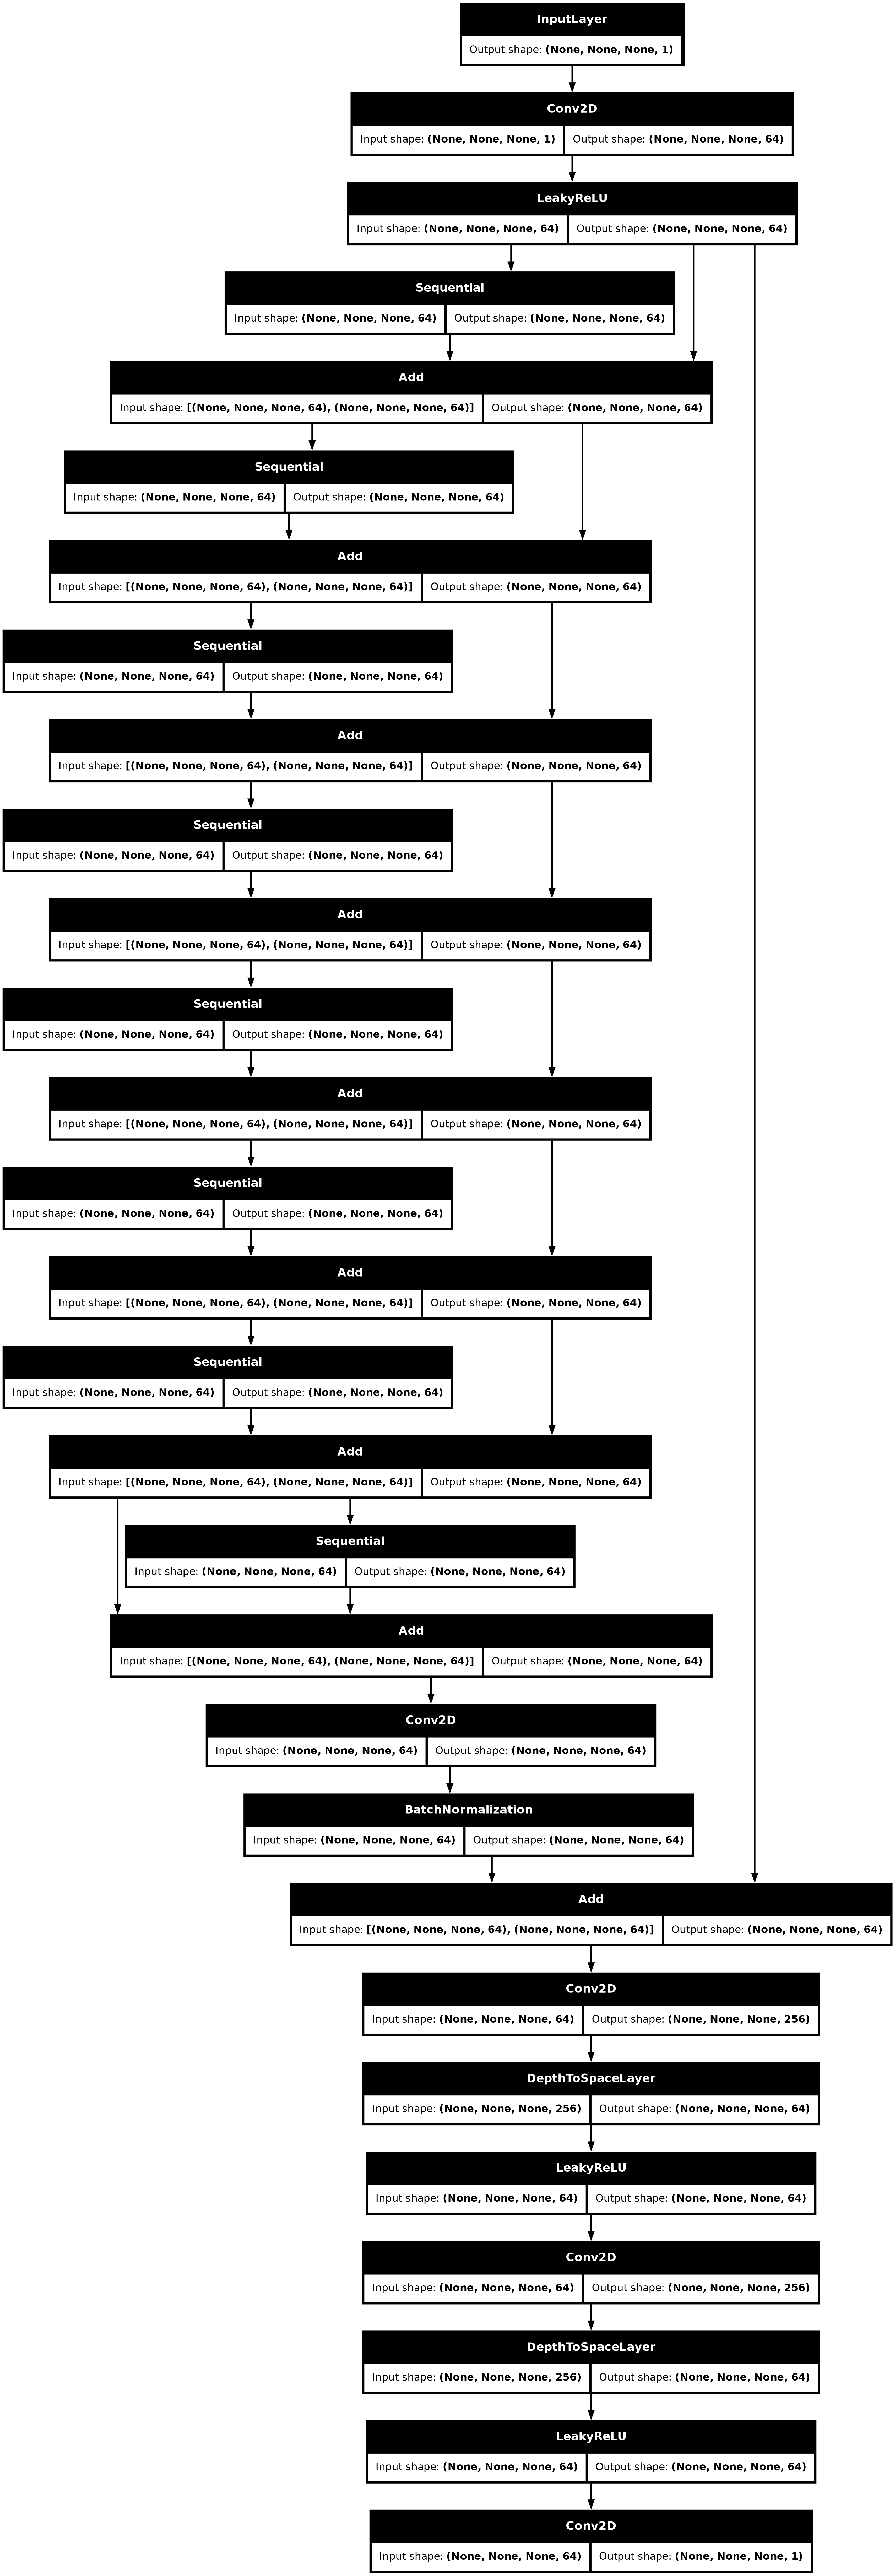

In [11]:
tf.keras.utils.plot_model(Generator, show_shapes=True)

In [12]:
Generator.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        640 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │     74,368 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ leaky_re_lu[0][0… │
│                     │ None, 64)         │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │     74,368 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │     74,368 │ add_1[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │     74,368 │ add_2[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None,      │          0 │ add_2[0][0],      │
│                     │ None, 64)         │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │     74,368 │ add_3[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ add_3[0][0],      │
│                     │ None, 64)         │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │     74,368 │ add_4[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None,      │          0 │ add_4[0][0],      │
│                     │ None, 64)         │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │     74,368 │ add_5[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None,      │          0 │ add_5[0][0],    

 Total params: 928,769 (3.54 MB)

 Trainable params: 926,593 (3.53 MB)

 Non-trainable params: 2,176 (8.50 KB)

# Discriminator (Critic)

In [13]:
def residual_block_disc(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same',
                               kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        # Optional: Move BatchNormalization after activation or remove
        # tf.keras.layers.BatchNormalization(),
    ])
    return model

input_lr = tf.keras.layers.Input(shape=(128, 128, 1))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(input_lr)
input_conv = tf.keras.layers.LeakyReLU(alpha=0.2)(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for x in range(7):
    disc = residual_block_disc(ch=channel_nums[x], st=stride_sizes[x])(disc)

disc = tf.keras.layers.Flatten()(disc)
#disc = tf.keras.layers.Droput(0.1)(disc)
disc = tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal())(disc)
disc = tf.keras.layers.LeakyReLU(alpha=0.2)(disc)
disc_output = tf.keras.layers.Dense(1)(disc) 
discriminator = tf.keras.models.Model(input_lr, disc_output)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
discriminator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,240,705 (145.88 MB)

 Trainable params: 38,240,705 (145.88 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extractor


In [15]:
from keras.models import load_model
def my_custom_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.9 * ssim_loss + 0.1* mse_loss
model = load_model('/kaggle/input/autoencoder_fe_imd/tensorflow2/default/1/autoencoder_fe.h5',custom_objects={'combined_loss': my_custom_loss})

In [16]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)
feature_extractor.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 256)            │     8,388,864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,942,528 (37.93 MB)

 Trainable params: 9,940,608 (37.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Training

In [17]:
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)

    gradients = tape.gradient(predictions, interpolated_images)
    gradients_sqr_sum = tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3])
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum + 1e-8)
    gradient_penalty = tf.reduce_mean((gradient_l2_norm - 1.0) ** 2)

    return gradient_penalty

In [18]:
def discriminator_loss(real_output, fake_output, gp, lambda_gp=10):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp


In [19]:
def generator_loss(fake_output, real_images, fake_images, feature_extractor_1):
    adv_loss = -tf.reduce_mean(fake_output)
    feature_loss = 0
    real_feature = feature_extractor(real_images)
    fake_feature = feature_extractor(fake_images)
    for real, fake in zip(real_feature, fake_feature):
        feature_loss += tf.reduce_mean(tf.abs(real - fake))
    mse_loss = tf.reduce_mean(tf.square(real_images - fake_images))
    total_loss =  1e-1*adv_loss + feature_loss+1e-1* mse_loss
    return total_loss

In [20]:
def plot_hr():
    sr = np.array(SR_pic_data[1901][0]).reshape((1, 128, 128, 1))
    sr = sr.astype(np.float16)
    generated = np.array(Generator(sr))
    array = np.copy(generated[0].reshape(512, 512))
    m = generated.max()
    array/=m
    array*=daily_max_SR[1901][0]
    array[array < 0] = np.nan
    # Longitude and Latitude for the grid
    lon = np.arange(len(lon25) * 4)
    lat = np.arange(len(lat25) * 4)
    X_SR, Y_SR = np.meshgrid(lon, lat)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the original generated image
    im1 = axes[0].contourf(X_SR, Y_SR, generated[0].reshape(512, 512), cmap='Blues')
    axes[0].set_title('Higher Resolution Rainfall')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    fig.colorbar(im1, ax=axes[0], label='Rainfall (mm/day)')

    # Plot the processed image
    im2 = axes[1].contourf(X_SR, Y_SR, array, cmap='Blues')
    axes[1].set_title('Processed Higher Resolution Rainfall')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    fig.colorbar(im2, ax=axes[1], label='Rainfall (mm/day)')

    plt.show()

In [21]:
def calculate_metrics(Generator, SR_data, LR_data):
    PSNR = []
    SSIM = []
    def generate_data():
        for year in range(1901, 2024):
            if year in [2002, 2003, 2023]:
                continue
            for i in range(len(SR_data[year])):
                yield LR_data[year][i], SR_data[year][i]

    dataset = tf.data.Dataset.from_generator(
        generate_data,
        output_signature=(
            tf.TensorSpec(shape=(32, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(128, 128), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(64) 

    for lr_batch, sr_batch in dataset:
        sr_images = Generator(lr_batch)
        sr_images_np = sr_images.numpy()
        for i in range(sr_images_np.shape[0]):
            data_range = sr_batch[i].numpy().max() - sr_batch[i].numpy().min()
            psnr_value = peak_signal_noise_ratio(sr_batch[i].numpy(), sr_images_np[i].reshape(128, 128), data_range=data_range)
            ssim_value = structural_similarity(sr_batch[i].numpy(), sr_images_np[i].reshape(128, 128), multichannel=False, data_range=data_range)
            PSNR.append(psnr_value)
            SSIM.append(ssim_value)
    return np.mean(PSNR), np.mean(SSIM)

In [22]:
PSNR = []
SSIM  = []

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.0, beta_2=0.9)

def train_step(SR_images, LR_images, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = Generator(LR_images, training=True)
        real_output = discriminator(SR_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, SR_images, fake_images)
        gen_loss = generator_loss(fake_output, SR_images, fake_images, feature_extractor)
        disc_loss = discriminator_loss(real_output, fake_output, gp)
    
    # Compute gradients for the generator, discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables ))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(SR_data, LR_data,PSNR,SSIM, epochs, batch_size):
    for epoch in range(epochs):
        for year in range(1901, 2024):
            if year in [2002, 2003, 2023]:
                continue
            days_in_year = len(LR_data[year])
            indices = np.arange(days_in_year)
            np.random.shuffle(indices)
            batches = [indices[i:i+batch_size] for i in range(0, days_in_year, batch_size)]

            for batch_indices in batches:
                lr = np.array([LR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 32, 32, 1))
                sr = np.array([SR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 128, 128, 1))
                gen_loss, disc_loss = train_step(sr, lr, len(batch_indices))
            if year%10==0:
                print(('I')*((year-1900)//10))
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
        psnr,ssim = calculate_metrics(Generator, SR_data, LR_data)
        PSNR.append(psnr)
        SSIM.append(ssim)
        print(f'PSNR:{psnr},SSIM:{ssim}')
        sr_pic = np.array(SR_data[1901][0])
        lr_pic = np.array(LR_data[1901][:32]).reshape((32, 32, 32, 1))
        generated = np.array(Generator(lr_pic))
        plt.figure(figsize=(21, 6))
        plt.subplot(1, 3, 1)
        X_SR, Y_SR = np.meshgrid(lon25, lat25)
        array = np.copy(generated[0].reshape(128, 128))
        array[array < 0] = np.nan
        plt.contourf(X_SR, Y_SR, generated[0].reshape(128, 128), cmap='Blues')
        plt.colorbar(label='Rainfall (mm/day)')
        plt.title('Generated Rainfall data')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.subplot(1, 3, 2)
        X_SR, Y_SR = np.meshgrid(lon25, lat25)
        array = generated[0].reshape(128, 128)
        array[array < 0] = np.nan
        plt.contourf(X_SR, Y_SR, array, cmap='Blues')
        plt.colorbar(label='Rainfall (mm/day)')
        plt.title('Processed Generated Rainfall data')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.subplot(1, 3, 3)
        plt.contourf(X_SR, Y_SR, sr_pic, cmap='Blues')
        plt.colorbar(label='Rainfall (mm/day)')
        plt.title('Actual Rainfall data')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
        plot_hr()
        Generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
        print(f'Models saved after epoch {epoch+1}')

I
II
III
IIII
IIIII
IIIIII
IIIIIII
IIIIIIII
IIIIIIIII
IIIIIIIIII
IIIIIIIIIII
IIIIIIIIIIII
Epoch 1, Generator Loss: 662.5382690429688, Discriminator Loss: -8.253616333007812


/opt/conda/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


PSNR:-inf,SSIM:nan


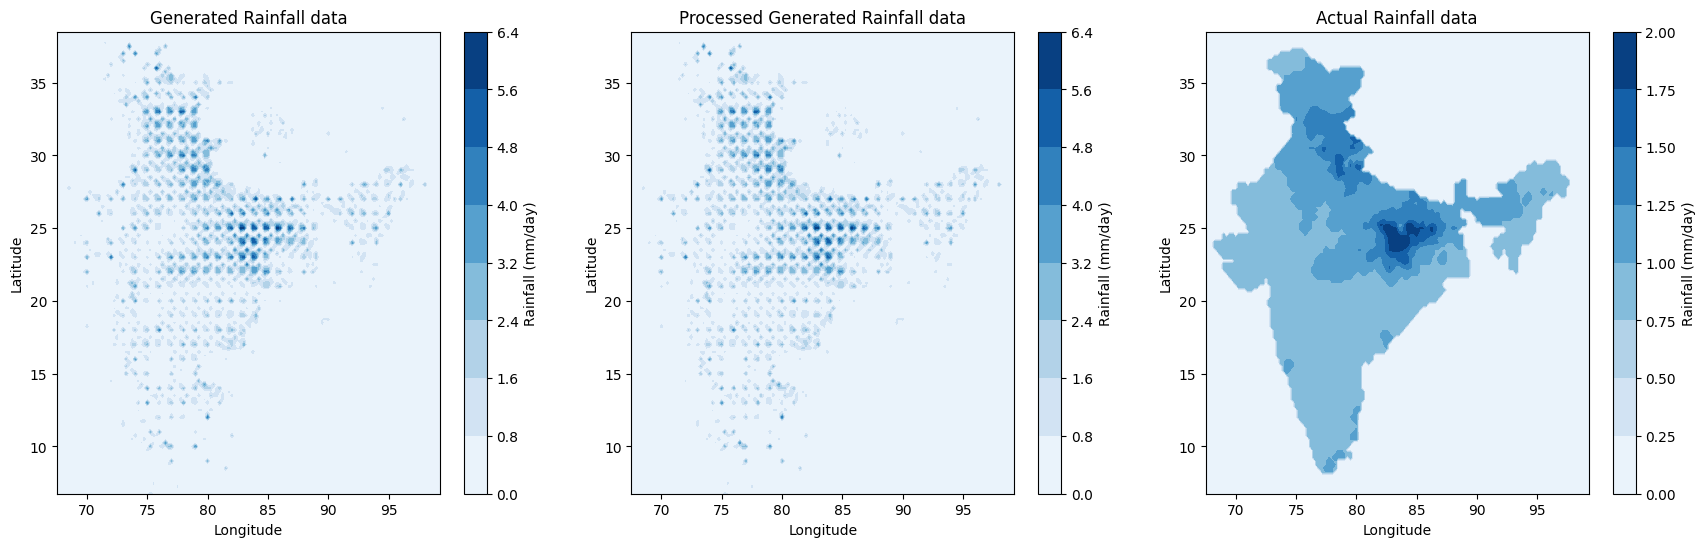

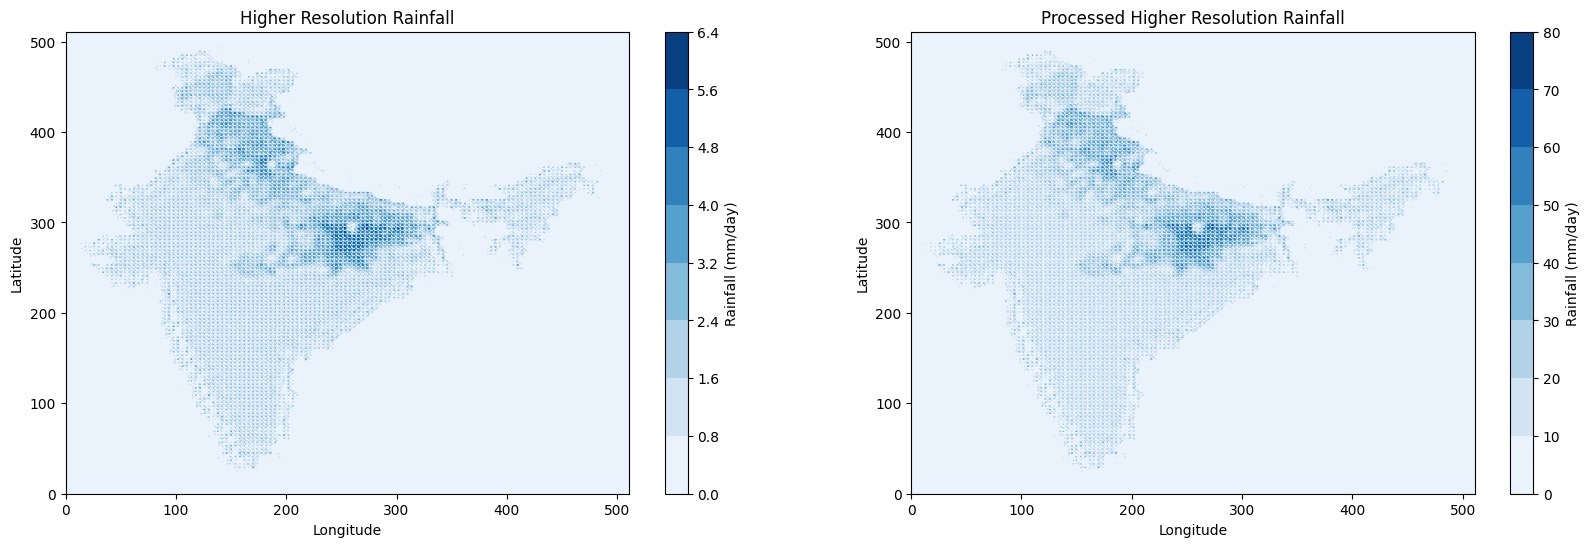

Models saved after epoch 1
I
II
III
IIII
IIIII
IIIIII
IIIIIII
IIIIIIII
IIIIIIIII
IIIIIIIIII
IIIIIIIIIII
IIIIIIIIIIII
Epoch 2, Generator Loss: 505.89654541015625, Discriminator Loss: -86.5146484375
PSNR:-inf,SSIM:nan


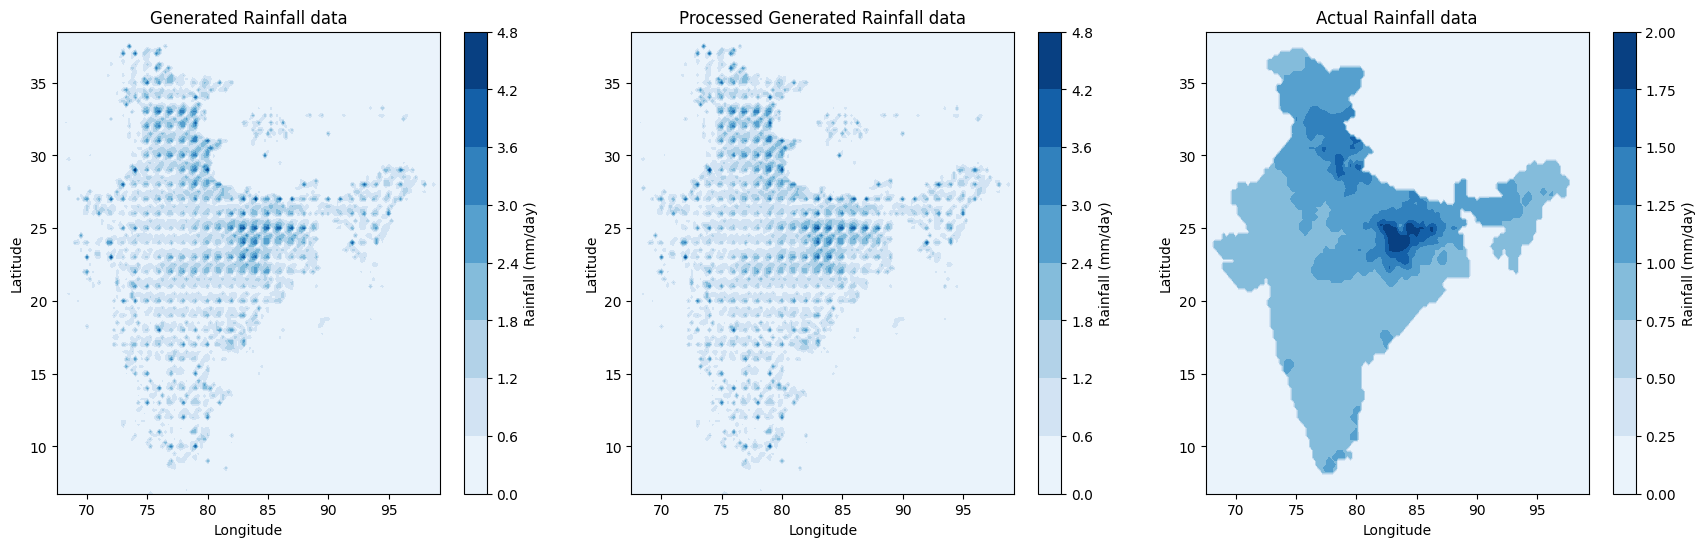

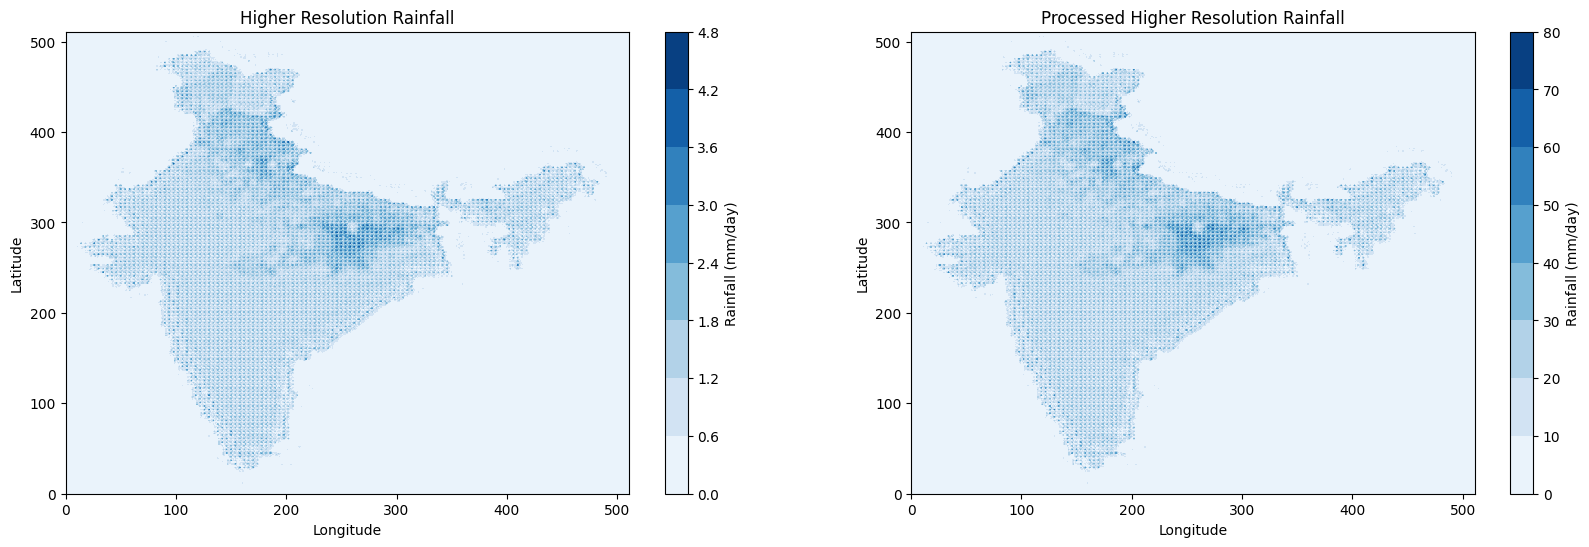

Models saved after epoch 2
I
II
III
IIII
IIIII
IIIIII
IIIIIII
IIIIIIII
IIIIIIIII
IIIIIIIIII
IIIIIIIIIII
IIIIIIIIIIII
Epoch 3, Generator Loss: 1806.317138671875, Discriminator Loss: 7544129.5
PSNR:-inf,SSIM:nan


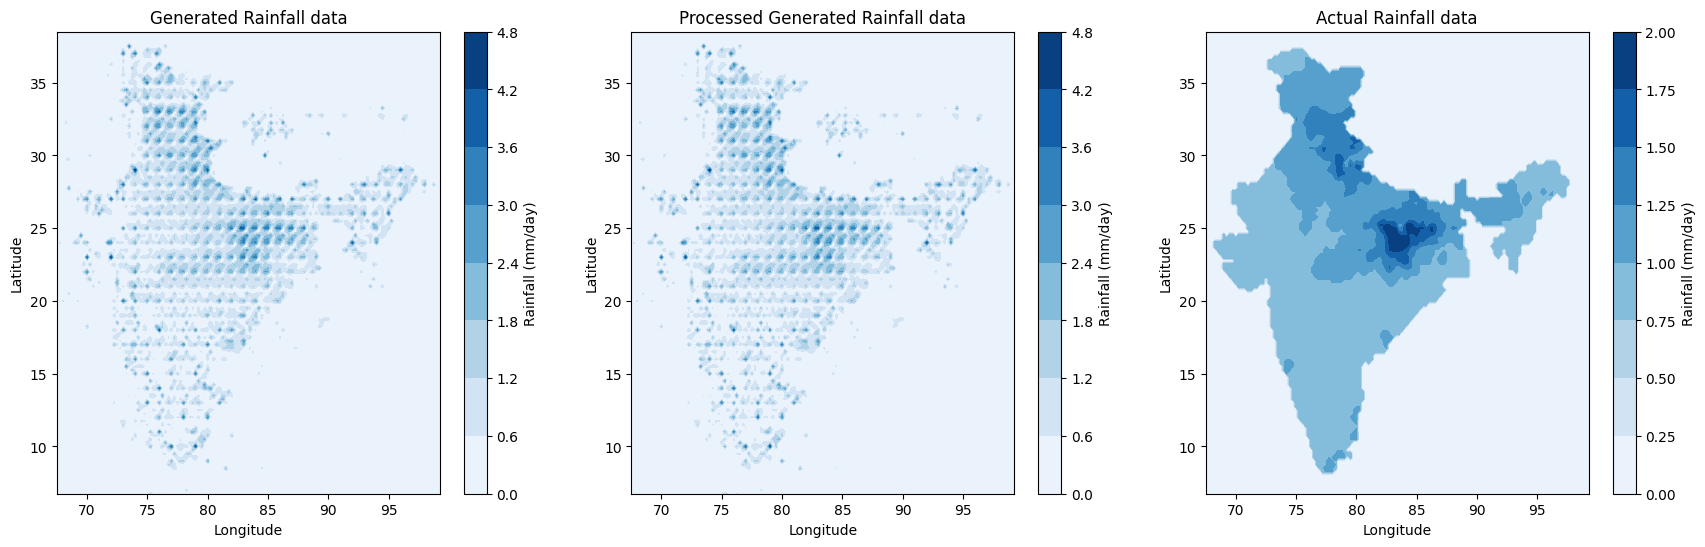

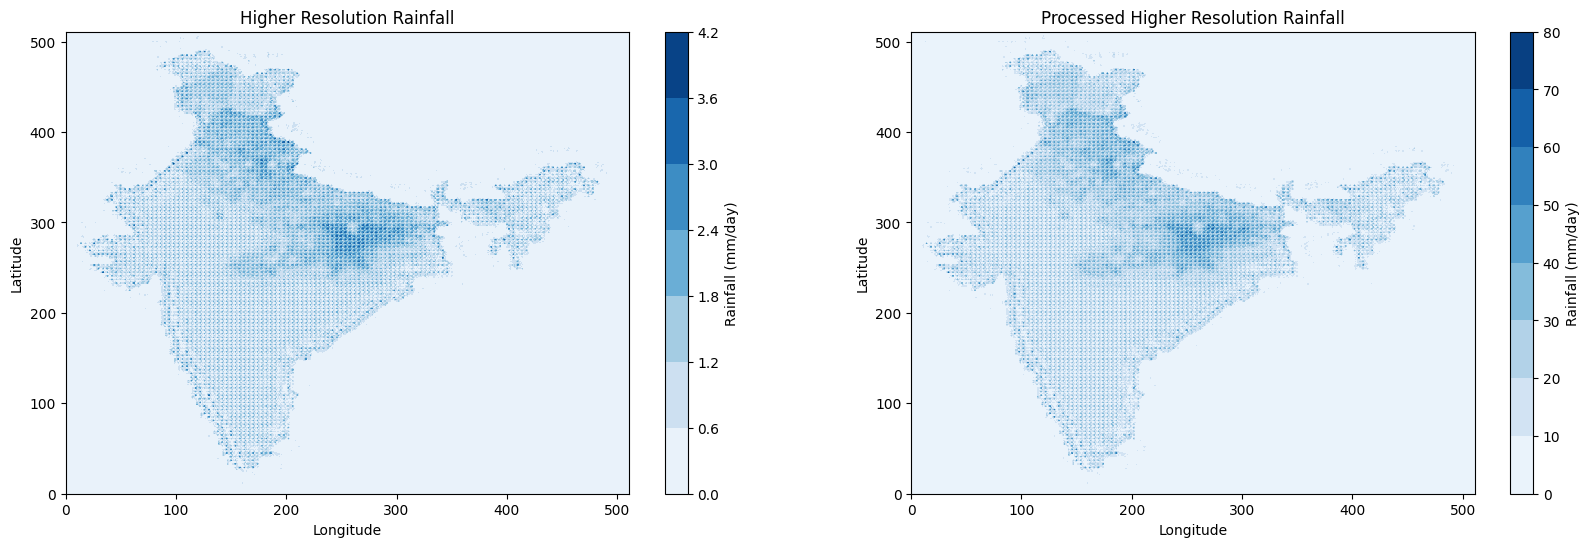

Models saved after epoch 3
I


In [ ]:
train(SR_pic_data,LR,PSNR,SSIM,epochs=5, batch_size=32)

# Evaluation

In [ ]:
epochs = np.arange(1, len(PSNR) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(epochs, PSNR, color='b', alpha=0.6, label='PSNR')
plt.plot(epochs, PSNR, color='b', marker='o', linestyle='-', linewidth=2, label='PSNR Line')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR per Epoch')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.bar(epochs, SSIM, color='r', alpha=0.6, label='SSIM')
plt.plot(epochs, SSIM, color='r', marker='o', linestyle='-', linewidth=2, label='SSIM Line')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# sr = np.array(SR_data[2000][0]).reshape((1, 128, 136, 1))
# sr = sr.astype(np.float16)
# generated = np.array(Generator(sr))
# print(generated[0].shape)

In [ ]:
# lon = np.arange(len(lon25)*4)
# lat = np.arange(len(lat25)*4)

In [ ]:
# plt.figure(figsize=(10, 6))
# X_SR, Y_SR = np.meshgrid(lon, lat)
# plt.contourf(X_SR, Y_SR, generated[0].reshape(512, 544), cmap='Blues')
# plt.colorbar(label='Rainfall (mm/day)')
# plt.title(f'Rainfall')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

In [ ]:
# plt.contourf(X_SR, Y_SR, generated[0].reshape(), cmap='Blues')
# plt.colorbar(label='Rainfall (mm/day)')
# plt.title('Actual Rainfall data')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()